### This notebook walks through loading a model, making a prediction with an image, and inspecting the outputs


by Evan B Goldstein, October 2022

In [1]:
#load up the basics
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

#If you have multiple GPU, set which one to use. 
# Numbering starts at 0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#import TF
import tensorflow as tf

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.9.1
 GPU: /device:GPU:0


In [2]:
#Load up the TF model
# here i am using a model trained to predict NOAA post storm images.
# it segments an RGB image into 4 classes (water, sand, vegetation, development)


#model path
model_path = './models/NOAA_NewLoss_fullmodel_model'

# load model into tf
model = tf.keras.models.load_model(model_path, compile = True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1024,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 768, 1024, 4  52          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 768, 1024, 4  16         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                )                                                                 
                                                                                                  
 activation_7 (Activation)      (None, 192, 256, 16  0           ['batch_normalization_7[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 192, 256, 16  20752       ['activation_6[0][0]']           
                                )                                                                 
                                                                                                  
 add_2 (Add)                    (None, 192, 256, 16  0           ['activation_7[0][0]',           
                                )                                 'conv2d_7[0][0]']               
          

 activation_15 (Activation)     (None, 48, 64, 64)   0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 48, 64, 64)   331840      ['activation_15[0][0]']          
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 96, 128, 64)  0           ['conv2d_16[0][0]']              
                                                                                                  
 concatenate (Concatenate)      (None, 96, 128, 96)  0           ['up_sampling2d[0][0]',          
                                                                  'add_3[0][0]']                  
                                                                                                  
 batch_normalization_16 (BatchN  (None, 96, 128, 96)  384        ['concatenate[0][0]']            
 ormalizat

                                                                                                  
 conv2d_25 (Conv2D)             (None, 384, 512, 16  656         ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_23 (BatchN  (None, 384, 512, 16  64         ['conv2d_23[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_24 (BatchN  (None, 384, 512, 16  64         ['conv2d_25[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activatio

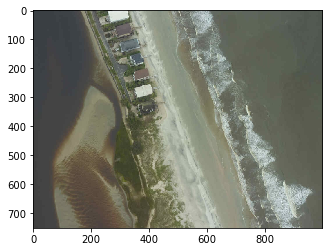

In [3]:
#load up an image
ImPath = "../data/images/C26047791-1_EBG.jpg"
img = matplotlib.image.imread(ImPath)
imgplot = plt.imshow(img)

In [4]:
#images are standardized before they are sent through the model:
#adjusted by standard deviation, as required by Gym model

def standardize(img):

    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0 / np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    del m, s, N
    #
    if np.ndim(img) == 2:
        img = np.dstack((img, img, img))

    return img

In [5]:
## And we convert he image to the right format and shape, 
# and then send it through the model

#model has a specific target size.. you can look at the model.summary() above.
im_targetsize = (768,1024)

TestIm = tf.keras.preprocessing.image.load_img(ImPath,target_size = im_targetsize)
TestIm = tf.keras.preprocessing.image.img_to_array(TestIm)
TestIm = standardize(TestIm)
TestIm = np.expand_dims(TestIm,axis=0)
print(TestIm.shape)
TestPred = model.predict(TestIm)
print(TestPred.shape)

# you can see the image is a 1,768,1024, 3 tensor 
#(1 image, 768 Height, 1024 length, 3 channels (RGB))

# and the output is a 1,768,1024, 4 tensor 
#(1 image, 768 Height, 1024 length, 3 channels (1 for each class))


(1, 768, 1024, 3)
1/1 [==============================] - 3s 3s/step
(1, 768, 1024, 4)


In [6]:
#So what are in the channels? these are the output softmax scores
#first lets get rid of the extra dimension
sq_TestPred = TestPred.squeeze()

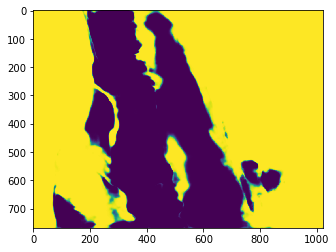

In [7]:
#lets look at the softmax scores for each class.. 

#This is the water score for each pixel
plt.imshow(sq_TestPred[:,:,0])


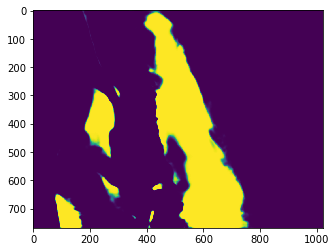

In [8]:
#This is the sand score for each pixel
plt.imshow(sq_TestPred[:,:,1])

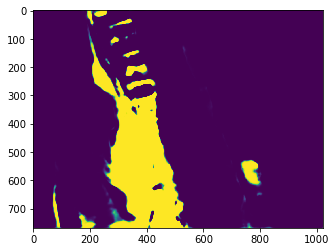

In [9]:
#This is the vegetation score for each pixel
plt.imshow(sq_TestPred[:,:,2])

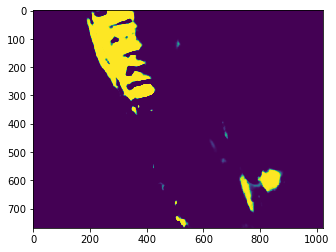

In [10]:
#This is the development (roads/houses) score for each pixel
plt.imshow(sq_TestPred[:,:,3])

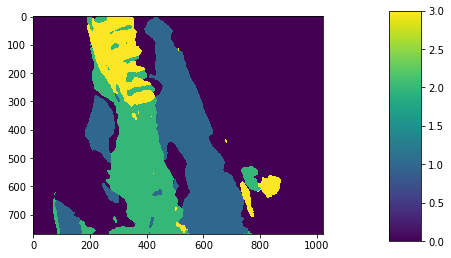

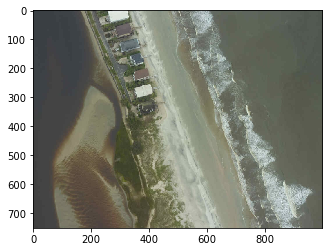

In [11]:
# to get the composite label, we need to take the argmax of these channels

#look at the argmaxed labels vs the image
# water (0), sand (1), vegetation (3), dev(4)

lab = np.argmax(sq_TestPred,-1)

plt.imshow(lab)
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()
plt.imshow(img)

In [12]:
# you can see that this basic prediction is definitely not perfect. 
# In the next notebooks we can investigate the actual quantitative scores vs a label, 
# and try to quantify how the model is being confused
# and how we can make the model better using Test Time Augmentation


